# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | NOMS - CODE PERMANENT                                   |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | SAISON ANNÉE                                            |
| Groupe                | X                                                       |
| Numéro du laboratoire | X                                                       |
| Professeur            | Prof. NOM                                               |
| Chargé de laboratoire | NOM                                                     |
| Date                  | DATE                                                    |

In [5]:
import numpy as np
import cv2
from scipy.misc import imread, imshow,face
import matplotlib.pyplot as plt


In [107]:
import numpy
import cv2
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

class Image:
    def __init__(self, path,label, answer):
        self._Path = path
        self._Label = label
        self._Answer = answer
        self._Pixels = numpy.array(cv2.imread(path))
        print(self._Pixels.shape)
        self._Width = self._Pixels.shape[0]
        self._Hight = self._Pixels.shape[1]
        #useful image manipulations
        self._GrayScale = rgb2gray(self._Pixels)
        self._Threshold = threshold_otsu(self._GrayScale)
        self._Binary = self._GrayScale > self._Threshold
        self.crop(self._Width)

    def crop(self, dimentions):
        self._Cropped = dimentions != self._Width
        # dimention is the width and hight to crop to. Since it is a square.
        upper_width = int(self._Width/2 + dimentions/2)
        lower_width = int(self._Width/2 - dimentions/2)
        upper_height = int(self._Hight/2 + dimentions/2)
        lower_height = int(self._Hight/2 - dimentions/2)
        self._CroppedPixels = self._Pixels[ lower_width:upper_width,lower_height : upper_height]
        self._CroppedGrayScale = rgb2gray(self._CroppedPixels)
        self._CroppedThreshold = threshold_otsu(self._CroppedGrayScale)
        self._CroppedBinary = self._CroppedGrayScale > self._CroppedThreshold
    
    def computeBlackWhite(self):
        self._Black = 0
        self._White = 0
        self._BlackWhiteRatio = 0
        self._CroppedBlack = 0
        self._CroppedWhite = 0
        self._CroppedBlackWhiteRatio = 0
        
        for row in self._Binary :
            for pixel in row:
                if(pixel):
                    self._White += 1
                else:
                    self._Black += 1
        #compute the B/W ratio
        if self._Black > 0 and self._White >0 :
            self._BlackWhiteRatio = self._Black / self._White
        
        if self._Cropped:
            for row in self._CroppedBinary :
                for pixel in row:
                    if(pixel):
                        self._CroppedWhite += 1
                    else:
                        self._CroppedBlack += 1
            #compute the cropped B/W ratio
            if self._CroppedBlack > 0 and self._CroppedWhite >0 :
                self._CroppedBlackWhiteRatio = self._CroppedBlack / self._CroppedWhite
        else:            
            self._CroppedBlack = self._Black
            self._CroppedWhite = self._White
            self._CroppedBlackWhiteRatio = self._BlackWhiteRatio

(424, 424, 3)
0.025784313725490195
grayscale fist value:  0.025784313725490195
threshold:  0.18756156173406865
binary first value:  False
0.12412117647058825
black  168944
white  10832
B/W ratio 15.596750369276219


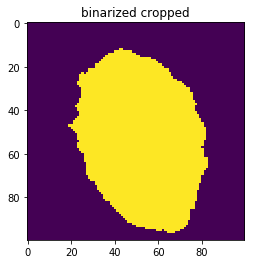

In [110]:
import numpy as np
import cv2
from scipy.misc import imread, imshow,face
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu

#test
img = Image("C:\\Users\\ThinkPad\\Downloads\\gti770\\data\\images\\100053.jpg","100053","smooth")
print(img._GrayScale[0][0])
plt.imshow(img._Pixels)
plt.title("original")
#plt.show()

print("grayscale fist value: ",img._GrayScale[0][0])
plt.imshow(img._GrayScale)
plt.title("grayscale")
#plt.show()

print("threshold: ",img._Threshold)
binary = img._GrayScale > img._Threshold
print("binary first value: ", binary[0][0])
plt.imshow(binary)
plt.title("binarized")
#plt.show()

img.crop(100)

plt.imshow(img._CroppedBinary)
print(img._CroppedGrayScale[0][0])
plt.title("binarized cropped")
#plt.show()

img.computeBlackWhite()
print("black ",img._Black)
print("white ", img._White)
print("B/W ratio", img._BlackWhiteRatio)

print("cropped black ",img._CroppedBlack)
print("cropped white ", img._CroppedWhite)
print("cropped B/W ratio", img._CroppedBlackWhiteRatio)

Introduction et revue de la littérature

### Question 2

### Question 3

### Question 4

### Question 5

### Conclusion

### Bibliographie